In [1]:
import re 
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaModel

import pyLDAvis
pyLDAvis.enable_notebook()

%matplotlib inline

stop_words = stopwords.words('english')

[nltk_data] Downloading package stopwords to /home/sxia1/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Extract $\alpha$ and $\beta$ from data
## clean up data and tokenize text
### personality data (ignore)

805
641
['Inventive and Curious' 'Consistent and Cautions'
 'Efficient/Organised and Planned' 'Easygoing/Careless and Spontaneous'
 'Outgoing and Energetic' 'Solidatory and Reserved'
 'Friendly and Compassionate' 'Cold and Unkind' 'Sensitive and Nervous'
 'Secure and Confident' 'Not_Well' 'Others']


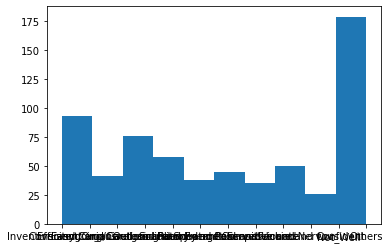

text             innovators are scientists looking for the best...
personalities                                Inventive and Curious
Name: 1, dtype: object
['innovators', 'are', 'scientists', 'looking', 'for', 'the', 'best', 'possible', 'solutions']


/tmp/ipykernel_624/2654732793.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['n_words']=list(map(lambda x:len(x),text_tokenized))


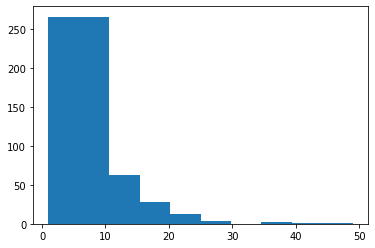

In [149]:
# read-in pre-labled tweets
df_raw = pd.read_excel("data/corpus_new.xlsx",sheet_name="Sheet1",names=["text","personalities"])
print(len(df_raw))
#skip non-english text
df = df_raw[df_raw['text'].apply(lambda x:x.isascii())]
print(len(df))
print(df.personalities.unique())
plt.hist(df['personalities'])
plt.show()
# tokenize each text
text_tokenized = list(map(lambda news:nltk.word_tokenize(re.sub(r'[^A_Za-z\s]','',news.lower())), df['text']))
len(text_tokenized)
print(df.iloc[0])
print(text_tokenized[0])
df['n_words']=list(map(lambda x:len(x),text_tokenized))
plt.hist(df.n_words)
plt.show()

### Web of science paper data

Text(0.5, 1.0, 'abstract word count')

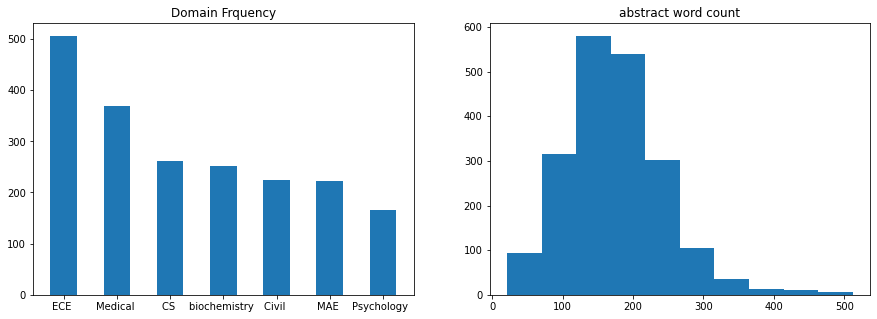

In [53]:
# read-in pre-labled research apper abstracts
df_paper_raw = pd.read_excel("data/WebOfScienceData.xlsx",sheet_name="abstracts")
print(len(df_paper_raw))
df_paper = df_paper_raw.head(2000) #use first 2000
print(df_paper.Domain.unique())

# remove puncutations and number, then tokenize each text
text_tokenized = list(map(lambda abstract_i:nltk.word_tokenize(re.sub(r'[^A-Za-z\s]','',abstract_i.lower())), df_paper['Abstract']))
len(text_tokenized)
df_paper['n_words']=list(map(lambda x:len(x),text_tokenized))

fig,axs = plt.subplots(1,2,figsize=(15,5))
categories = df_paper.Domain.value_counts().index
counts = df_paper.Domain.value_counts().values
axs[0].bar(categories, counts, width=0.5)
axs[0].set_title("Domain Frquency")
axs[1].hist(df_paper.n_words)
axs[1].set_title("abstract word count")

## remove stopwords, make biargam, lemmatize

/tmp/ipykernel_28485/1063011778.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['n_words_removed']=list(map(lambda x:len(x),abstract_lemmatized))


Text(0.5, 1.0, 'abstract without stop words word count')

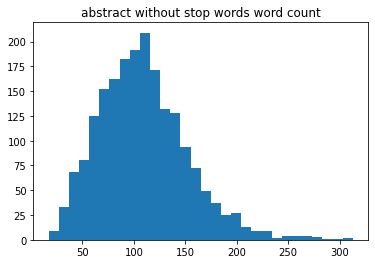

In [55]:
#helper function for lemmatization
def get_wordnet_pos(tag):

    if tag.startswith('J'):
        return 'a'
    elif tag.startswith('V'):
        return 'v'
    elif tag.startswith('R'):
        return 'r'
    else:
        return 'n' #if not belong to any, default is noun, inclunding N

def lemmatize_with_pos(abstract_toekenized):
    abstract_tagged = nltk.pos_tag(abstract_toekenized)
    tags = list(map(lambda token: get_wordnet_pos(token[1]),abstract_tagged))
    abstract_lemmatized = list(map(lemmatizer.lemmatize,abstract_toekenized,tags))
    return abstract_lemmatized


# Creating Bigram: find words frequently occur together
bigram = gensim.models.Phrases(text_tokenized, min_count=20, threshold=50)  
#come back to adjust the threshold value: (cnt(a, b) - min_count) * N / (cnt(a) * cnt(b)) > threshold
bigram_freeze = bigram.freeze()
#import nltk lemmatizer
lemmatizer = WordNetLemmatizer()

def prepare_token(text_tokenized_list):
    # remove stopwords and puntuation, 
    text_stopwords_removed = list(map(lambda abstract: list(filter(lambda word: word not in stop_words, abstract)),text_tokenized_list))

    #apply biagram model
    word_and_bigram_list = list(map(lambda abstract_cleaned: bigram[abstract_cleaned],text_stopwords_removed))

    # lemmatize
    abstract_lemmatized = list(map(lemmatize_with_pos,word_and_bigram_list))
    return abstract_lemmatized

abstract_lemmatized = prepare_token(text_tokenized)
df_paper['n_words_removed']=list(map(lambda x:len(x),abstract_lemmatized))
plt.hist(df_paper.n_words_removed,bins=30)
plt.title("abstract without stop words word count")

['use', 'model', 'system', 'study', 'method', 'propose', 'result', 'control', 'present', 'base', 'show', 'design', 'analysis', 'high', 'cell', 'data', 'also', 'patient', 'effect', 'increase', 'two', 'different', 'time', 'develop', 'process', 'provide', 'new', 'paper', 'include', 'rights_reserved', 'approach', 'compare', 'performance', 'test', 'algorithm', 'level', 'low', 'c_elsevier', 'power', 'measure', 'well', 'structure', 'condition', 'energy', 'find', 'function', 'one', 'may', 'parameter', 'application']


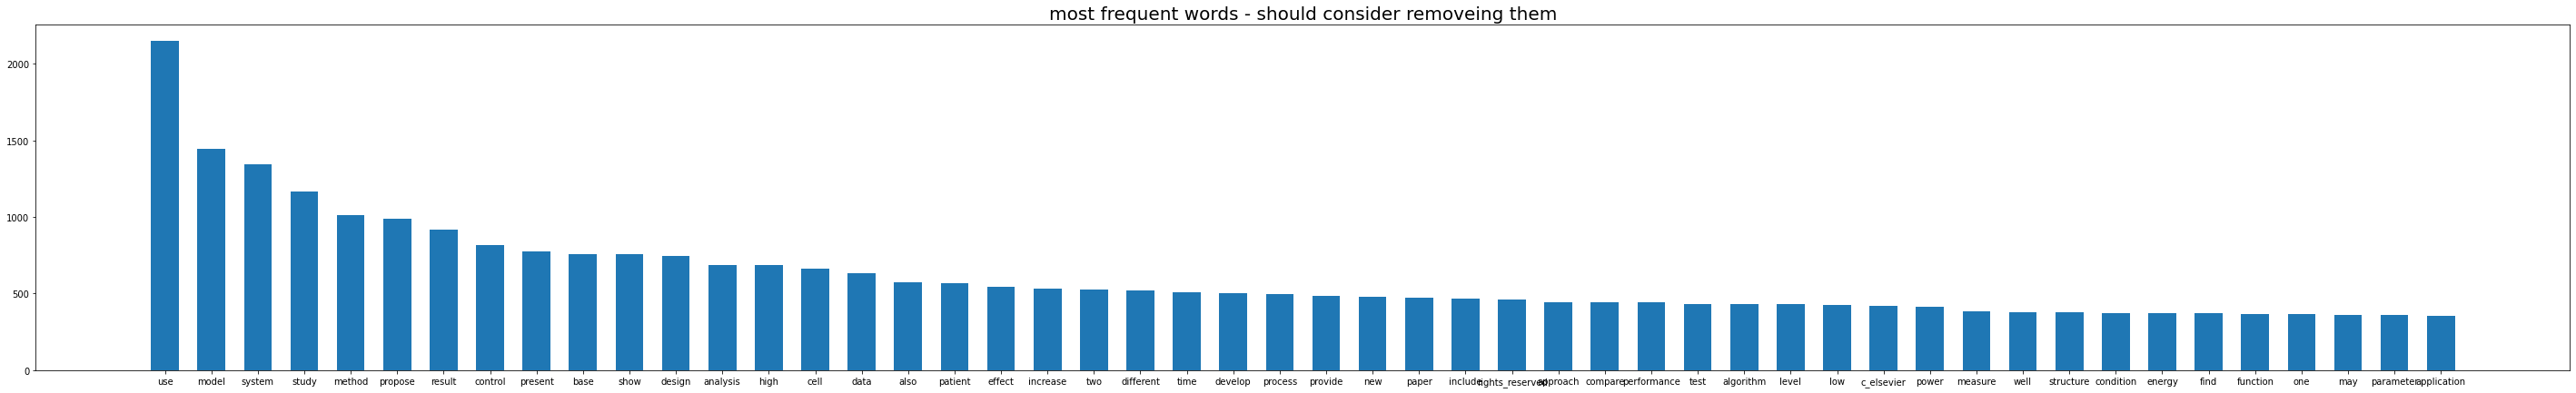

In [88]:
def check_frequent_words(corpus,top_n):
    all_corpus_together=np.concatenate(corpus)
    (word, counts) = np.unique(all_corpus_together, return_counts=True)
    frequencies = np.asarray((word, counts)).T
    count_df = pd.DataFrame(data=frequencies,columns = ['word','freq'])
    count_df.freq = count_df.freq.astype(int)
    count_df.sort_values(by=['freq'],axis=0,ascending=False,ignore_index=True,inplace=True)
    print(list(count_df.head(top_n).word))
    plt.figure(figsize=(top_n,7))
    plt.bar(count_df[:top_n].word,height=count_df[:top_n].freq,width=0.6,align='center')
    plt.title("most frequent words - should consider removeing them",fontsize=20)
    plt.show()

check_frequent_words(abstract_lemmatized,50)

['function', 'one', 'may', 'parameter', 'application', 'simulation', 'current', 'obtain', 'group', 'change', 'dynamic', 'frequency', 'circuit', 'improve', 'work', 'expression', 'treatment', 'reduce', 'response', 'demonstrate']


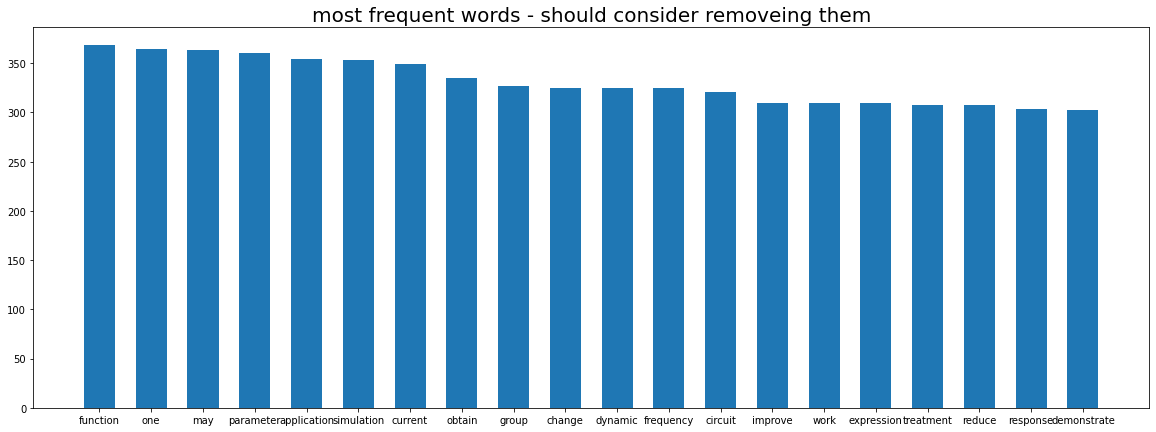

/tmp/ipykernel_28485/1674481856.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_paper['n_words_lemmatize_clean']=list(map(lambda x:len(x),abstract_lemmatized_cleaned))


Text(200, 150, 'median length: 90')

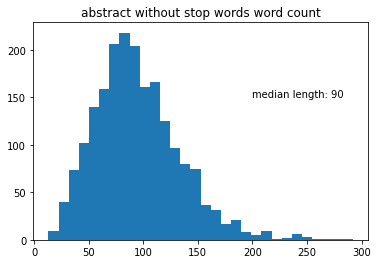

In [110]:
# remove top 50 most frequent words
top_n = list(count_df[:45].word)
abstract_lemmatized_cleaned = list(map(lambda abstract: list(filter(lambda word: word not in top_n, abstract)),abstract_lemmatized))
check_frequent_words(abstract_lemmatized_cleaned,top_n=20)

df_paper['n_words_lemmatize_clean']=list(map(lambda x:len(x),abstract_lemmatized_cleaned))
median_count = np.median(df_paper.n_words_lemmatize_clean)
plt.hist(df_paper.n_words_lemmatize_clean,bins=30)
plt.title("abstract without stop words word count")
plt.text(200,150,"median length: %d"%median_count,fontsize=10)


In [101]:
np.median(df_paper.n_words_lemmatize_clean)

90.0

In [102]:
"median length: %d"%np.median(df_paper.n_words_lemmatize_clean)

'median length: 90'

## make dictionary and corpus for the inputs to Gensim LDA Model

In [90]:
# define mapping between words to integer ids
word2id = Dictionary(abstract_lemmatized_cleaned)
dictionary = word2id.token2id
vocab_size = len(dictionary)
print("total vocabulary size", vocab_size)
# word2id.token2id gives the dictonary between words and their ids

# define corpus from documents
# documents: a list of lists of strings
# corpus: bag of words: each text = [(word_id, frequency), (word_id, frequency)]
corpus = list(map(word2id.doc2bow,abstract_lemmatized))
print([(word2id[id], freq) for id, freq in corpus[1]])

total vocabulary size 22094
[('p', 1), ('suggest', 1), ('accumulates', 1), ('accumulation', 2), ('across', 1), ('adult', 1), ('age', 2), ('aggregate', 1), ('among', 1), ('ap', 1), ('appear', 1), ('association', 7), ('av', 7), ('become', 1), ('beta', 5), ('betaamyloid', 1), ('brain', 1), ('calculate', 1), ('cluster', 1), ('cognitively', 1), ('correlate', 1), ('correlation', 1), ('correlational', 1), ('cortex', 2), ('cortical', 1), ('cpib', 1), ('demonstrate', 1), ('drive', 1), ('elderly', 1), ('emission', 1), ('examine', 1), ('fav', 1), ('follow', 1), ('fraction', 1), ('frequent', 1), ('frontoparietal', 1), ('global', 1), ('gray', 1), ('however', 1), ('identify', 1), ('image', 2), ('importantly', 1), ('increased', 1), ('increasingly', 1), ('indicate', 1), ('interest', 1), ('kmeans', 1), ('largely', 1), ('less', 1), ('lobe', 3), ('local', 4), ('location', 2), ('magnetic_resonance', 1), ('many', 1), ('matter', 1), ('mean', 1), ('mri', 1), ('multiple', 2), ('nb', 1), ('nonlocal', 3), ('nor

## Use LDA to extract topic distribution and topic-term distribution

In [91]:
# Train the model on the corpus.
lda_model = LdaModel(corpus, num_topics=len(df_paper.Domain.unique()),id2word = word2id)
## Save model to disk.
# temp_file = datapath("model")
# lda.save(temp_file)

# alpha = prior distribution over topic weights in each document. higer alpha more towards the center, i.e. a mixture of different topic
document_topic_weight = lda_model.alpha
print(document_topic_weight)

#beta = #distribution over word weights in each topic
topic_term_distribution = lda_model.eta

print(lda_model.print_topics(num_words=7)) 
#okay, i think i need remove "model", "use", "method", "system", "purpose", "result", "study", "show"



[0.14285715 0.14285715 0.14285715 0.14285715 0.14285715 0.14285715
 0.14285715]
[(0, '0.002*"improve" + 0.002*"reduce" + 0.002*"current" + 0.002*"signal" + 0.002*"dynamic" + 0.002*"controller" + 0.002*"factor"'), (1, '0.003*"simulation" + 0.003*"technique" + 0.003*"one" + 0.002*"area" + 0.002*"current" + 0.002*"demonstrate" + 0.002*"temperature"'), (2, '0.005*"circuit" + 0.002*"frequency" + 0.002*"change" + 0.002*"obtain" + 0.002*"stress" + 0.002*"material" + 0.002*"water"'), (3, '0.003*"function" + 0.003*"material" + 0.003*"network" + 0.002*"current" + 0.002*"application" + 0.002*"field" + 0.002*"rate"'), (4, '0.002*"may" + 0.002*"group" + 0.002*"c" + 0.002*"expression" + 0.002*"suggest" + 0.002*"measurement" + 0.002*"sample"'), (5, '0.003*"parameter" + 0.002*"human" + 0.002*"work" + 0.002*"report" + 0.002*"type" + 0.002*"suggest" + 0.002*"group"'), (6, '0.003*"may" + 0.003*"application" + 0.002*"equation" + 0.002*"response" + 0.002*"dynamic" + 0.002*"function" + 0.002*"frequency"')]


## evalute model perplexity and coherence 
how to interpret these scores?

In [92]:
# A lower perplexity score indicates better generalization performance.
perplexity = lda_model.log_perplexity(corpus)
print('Perplexity: ', perplexity )

# get coherence value u_mass
# probability = the number of documents in which the word occurs divided by the total number of documents"
cm = CoherenceModel(model=lda_model, corpus=corpus, dictionary = word2id,coherence='u_mass')
coherence_umass = cm.get_coherence() 
print('UMass Coherence Score: ', coherence_umass)

# Compute Coherence Score using c_v
# CV measure is based on the Pointwise Mutual Information score
coherence_model_lda = CoherenceModel(model=lda_model, texts=abstract_lemmatized_cleaned, dictionary=word2id, coherence="c_v")
coherence_cv = coherence_model_lda.get_coherence()
print('C_v Coherence Score: ', coherence_cv)

Perplexity:  -9.106814583583741
UMass Coherence Score:  -2.839113031131366
C_v Coherence Score:  0.2430520926993465


## visualize the model
based on the term distribution: 
['CS ', 'Medical ', 'Civil ', 'ECE ', 'biochemistry ', 'MAE ','Psychology  '],

In [93]:
vis_ldamodel = pyLDAvis.gensim_models.prepare(lda_model,corpus,word2id)
vis_ldamodel

/home/sxia1/.nlp_env/lib/python3.8/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only
  default_term_info = default_term_info.sort_values(


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
0     -0.018440 -0.004579       1        1  18.338053
4      0.004119 -0.021484       2        1  15.439841
3      0.017588 -0.015101       3        1  15.115543
6     -0.036326  0.030115       4        1  13.335499
1      0.006999  0.003835       5        1  12.904158
5     -0.010205 -0.023137       6        1  12.813352
2      0.036264  0.030351       7        1  12.053553, topic_info=            Term        Freq       Total Category  logprob  loglift
3481     circuit  283.000000  283.000000  Default  30.0000  30.0000
1188  controller  179.000000  179.000000  Default  29.0000  29.0000
3757  adolescent  112.000000  112.000000  Default  28.0000  28.0000
618        human  255.000000  255.000000  Default  27.0000  27.0000
1639      scheme  167.000000  167.000000  Default  26.0000  26.0000
...          ...         ...         ...      ...      ...      ...
329        order   33.020561  235.773381   Topic7  -6.5372   0.1501
433      current   34.249252  313.810255   Topic7  -6.5006  -0.0993
343       report   32.707106  247.579283   Topic7  -6.5467   0.0917
377     function   33.469102  330.933390   Topic7  -6.5237  -0.1755
1280        work   31.862268  278.145223   Topic7  -6.5729  -0.0509

[638 rows x 6 columns], token_table=       Topic      Freq          Term
term                                
20731      7  0.576425  accelerative
354        1  0.202093       achieve
354        2  0.106099       achieve
354        3  0.131360       achieve
354        4  0.090942       achieve
...      ...       ...           ...
7123       2  0.107302           yaw
7123       4  0.107302           yaw
7011       6  0.163208       zeolite
7011       7  0.816040       zeolite
12125      6  0.742309           zoo

[2021 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[1, 5, 4, 7, 2, 6, 3])

In [96]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=5, step=3):
    """
    Compute c_v coherence for various number of topics
    """
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = LdaModel(corpus,num_topics=num_topics,id2word = dictionary)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence="c_v")
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=word2id, corpus=corpus, texts=abstract_lemmatized_cleaned, start=5, limit=12, step=1)

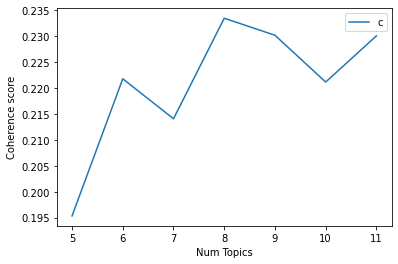

In [97]:
n = range(5, 12, 1)
plt.plot(n, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

## Using the LDA model, find the topic of any given document
Naive Bayes:
argmax_{topic} p(words|topic)p(topic)
argmax_{topic} p(word1|topic)p(word2|topic)...|p(topic)
argmax_{topic} \sum_{word_i} logP(word_i|topic)|p(topic)

In [194]:
# step1:  given an abstract/text, tokenize, find biargram, remove popular words
def prepare_text(text_list):
    tokenized = list(map(lambda text_i:nltk.word_tokenize(re.sub(r'[^A-Za-z\s]','',text_i.lower())),text_list))
    text_uncategorized = prepare_token(tokenized)
    # map corpus to a bag of words, lda doc2idx ignore unknown words
    corpus_uncategorized  = list(map(lambda document: word2id.doc2bow(document, return_missing=True),text_uncategorized))
    return corpus_uncategorized
text_list = df_paper.Abstract[50:52]
corpus_uncategorized = prepare_text(text_list)

corpus_i = corpus_uncategorized[0]
# corpus_reshape

In [197]:
topic_dist_inferred = lda_model[corpus_uncategorized[0]]
topic_dist_inferred[0]

[(0, 0.039716907),
 (1, 0.11430834),
 (2, 0.78589445),
 (3, 0.034446858),
 (4, 0.02384195)]

# use $\alpha$ and $\beta$ to generate synthetic data

In [210]:
# Possion distribution: draw sample length, lambda = median from the data
# alpha: topic mixture of each synethic text
# beta: topic-term distribution
def lda_gen(vocabulary,beta,alpha,possion_lambda):
    xi = np.random.poisson(possion_lambda)
    v = np.shape(beta)[0]
    topic_proportion = np.random.dirichlet(alpha) # generate topic proportion dist based on lambda
    topic_list = np.random.choice(range(v),xi,p=topic_proportion) #sample from topic proportion dist

    #pick a word for each topic in each document
    # frequency of the topics = topics mixture in each document
    word_bag = []
    for topic_index in topic_list:
        word = np.random.choice(vocabulary,p=beta[topic_index])
        word_bag.append(word)
    return word_bag



In [211]:
vocabulary = list(dictionary.keys())
alpha = document_topic_weight
beta = lda_model.get_topics()
possion_lambda = median_count

synthetic_data_size = 30
synthetic_data = [ lda_gen(vocabulary,beta,alpha,possion_lambda) for _ in range(synthetic_data_size)]


In [204]:
print(word_bags)

['job', 'livestock', 'attractive', 'complicate', 'weak', 'frequent', 'vittorio', 'cfpolyetheretherketone', 'rat', 'question', 'neuron', 'glycol', 'expression', 'size', 'exist', 'temporal', 'object', 'stressrelated', 'vary', 'extraribosomal', 'block', 'genetic', 'apply', 'receptor', 'aggravate', 'main', 'swollen', 'central', 'component', 'brownlike', 'roughness', 'corrosion', 'phenomenological', 'interrupt', 'filament', 'highly', 'cayley', 'sortandselect', 'equivalent', 'continue', 'cancer', 'herein', 'ebvtr', 'analyse', 'cost', 'hydroxyoxobutyl', 'basolateral', 'recent', 'carrier', 'advancement', 'feces', 'theoretical', 'microscopy', 'rna', 'root', 'accurate', 'markedly', 'sem', 'specific', 'accurate', 'selfsustaining', 'call', 'mutual', 'gridfeeding', 'broadangle', 'prototype', 'stability', 'detect', 'hyperfocusing', 'observe', 'front', 'via', 'hyphal', 'uncorrected', 'analytical', 'bpy', 'million', 'music', 'event', 'classifier', 'albuminglobulin', 'presence']
